https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-santander-value

https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

In [1]:
import os
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [29]:
labeled = pd.read_csv(r'../data/train.csv')
print(labeled.shape)

(4459, 4993)


In [4]:
labeled.columns

Index(['ID', 'target', '48df886f9', '0deb4b6a8', '34b15f335', 'a8cb14b00',
       '2f0771a37', '30347e683', 'd08d1fbe3', '6ee66e115',
       ...
       '3ecc09859', '9281abeea', '8675bec0b', '3a13ed79a', 'f677d4d13',
       '71b203550', '137efaa80', 'fb36b89d9', '7e293fbaf', '9fc776466'],
      dtype='object', length=4993)

### Take a look at the Y distribution
- Might want to take log of right-skewed money values (non-neg; log(Y)~normal => good for linear regression)

Text(0.5,1,'Target Histogram')

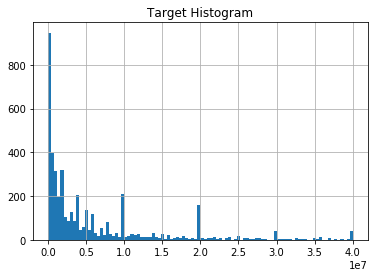

In [5]:
labeled['target'].hist(bins=100)
plt.title("Target Histogram")

Text(0.5,1,'Log Target Histogram')

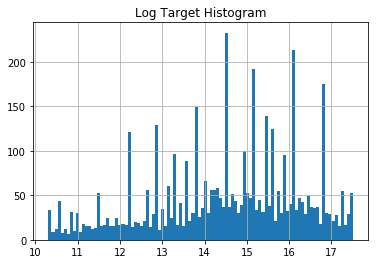

In [6]:
labeled['target'].map(np.log).hist(bins=100)
plt.title('Log Target Histogram')

### Take a look at X
- missing values?
- data types?
- constants?

In [7]:
missing_df = labeled.isnull().sum(axis=0).reset_index()
missing_df.columns=['col','NAs']
missing_df[missing_df.NAs!=0]

,col,NAs


In [8]:
dtype_df = labeled.dtypes.reset_index()
dtype_df.groupby(0).count() # all numeric

,index
0,
int64,3147
float64,1845
object,1


In [6]:
constant_df = labeled.nunique().reset_index()
constant_df.columns = ['col','unique_vals']
len(constant_df[constant_df.unique_vals==1])

256

In [7]:
const_col = list(constant_df[constant_df.unique_vals==1].col.values)
len(const_col)

256

with open(r'../input/drop_cols.txt',"w") as f:
    for col in const_col:
        f.write(col+",")

#### Linear model - correlation of features with log(Y)

In [30]:
labeled.drop(labels=const_col,axis=1,inplace=True)
print(labeled.shape)

(4459, 4737)


In [40]:
print(labeled[['target','48df886f9']].corr().values[0,1])
print(np.log(labeled[['target','48df886f9']]+1).corr().values[0,1])

0.010188021496986742
-0.093486991854408


In [32]:
%%time
feature_dict={}
for feature in labeled.columns[2:]:
    feature_dict[feature] = [labeled[['target',feature]].corr().values[0,1],
                             np.log(labeled[['target',feature]]+1).corr().values[0,1]]

Wall time: 8.85 s


In [33]:
feat_corr_df = pd.DataFrame.from_dict(feature_dict, orient='index').reset_index()
feat_corr_df.columns = ['feat','corr','corr_log']
feat_corr_df['corr_abs'] = feat_corr_df['corr'].map(np.abs)
feat_corr_df['corr_log_abs'] = feat_corr_df['corr_log'].map(np.abs)

In [35]:
feat_corr_df.sort_values('corr_abs',ascending=False)[:20]

,feat,corr,corr_log,corr_abs,corr_log_abs
4476,555f18bd3,0.273379,0.080247,0.273379,0.080247
2617,9fd594eec,0.270019,0.070267,0.270019,0.070267
2342,5bc7ab64f,0.267858,0.058510,0.267858,0.058510
3337,cbbc9c431,0.265005,0.065838,0.265005,0.065838
4135,f190486d6,0.263821,0.087129,0.263821,0.087129
4707,6b119d8ce,0.258290,0.049317,0.258290,0.049317
4190,f74e8f13d,0.257238,0.001771,0.257238,0.001771
570,ac30af84a,0.256292,0.069327,0.256292,0.069327
537,26fc93eb7,0.255186,0.019419,0.255186,0.019419
2378,58e2e02e6,0.254984,0.075589,0.254984,0.075589


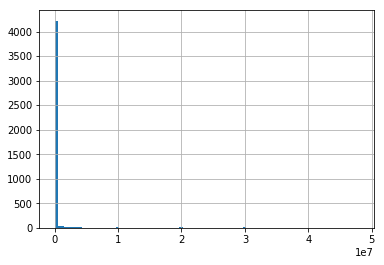

In [14]:
labeled['555f18bd3'].hist(bins=100)

In [15]:
(labeled['555f18bd3']!=0).sum() # ok, very sparse

324

In [16]:
%%time
feature_sparse_dict={}
for feature in labeled.columns[2:]:
    feature_sparse_dict[feature] = (labeled[feature]!=0).sum()

Wall time: 1.35 s


In [36]:
feat_sparse_df = pd.DataFrame.from_dict(feature_sparse_dict,orient='index').reset_index()
feat_sparse_df.columns = ['feat','values']
print(feat_sparse_df['values'].describe())
feat_sparse_df.sort_values('values',ascending=False)[:5]

count    4736.000000
mean      148.768581
std       225.664966
min         1.000000
25%        15.000000
50%        70.500000
75%       180.000000
max      4459.000000
Name: values, dtype: float64


,feat,values
4735,log_target,4459
1953,0ff32eb98,1565
4321,c5a231d81,1565
2934,91f701ba2,1560
4513,c47340d97,1555


In [38]:
feats = pd.merge(feat_corr_df, feat_sparse_df,how='inner',on='feat')
print(feats.shape)
feats[:3]

(4735, 6)


,feat,corr,corr_log,corr_abs,corr_log_abs,values
0,48df886f9,0.010188,-0.093487,0.010188,0.093487,39
1,0deb4b6a8,0.013805,0.014360,0.013805,0.014360,4
2,34b15f335,0.014694,0.006627,0.014694,0.006627,33


In [59]:
feats.to_csv(r'../input/feat_corr_sparse.txt',index=False) # write out for future use

In [48]:
## Take the top non-sparse linear features
feats[(feats['values']>500) & (feats.corr_log_abs>=0.05)].sort_values(by='corr_log_abs',ascending=False)

,feat,corr,corr_log,corr_abs,corr_log_abs,values
282,63c094ba4,0.160249,0.087973,0.160249,0.087973,742
4135,f190486d6,0.263821,0.087129,0.263821,0.087129,1544
1008,1c71183bb,0.231546,0.084806,0.231546,0.084806,721
4327,0d51722ca,0.173851,0.084297,0.173851,0.084297,764
34,87ffda550,0.175618,0.083497,0.175618,0.083497,754
440,e078302ef,0.182266,0.082101,0.182266,0.082101,739
3334,122c135ed,0.201425,0.080153,0.201425,0.080153,790
871,83c3779bf,0.064078,-0.078681,0.064078,0.078681,664
2750,d5fa73ead,0.164278,0.077762,0.164278,0.077762,719
2378,58e2e02e6,0.254984,0.075589,0.254984,0.075589,1513


In [49]:
top_non_sparse_feat = feats[(feats['values']>500) & (feats.corr_log_abs>=0.05)].sort_values(by='corr_log_abs',ascending=False)['feat'].values.tolist()

In [50]:
y = labeled['target']
X = labeled[top_non_sparse_feat]

In [51]:
X_train, X_val, y_train, y_val = train_test_split(np.log(X+1),y,test_size=0.2,random_state=1)

In [52]:
ln = LinearRegression()
ln.fit(X_train,np.log(y_train))
print(ln.score(X_train,np.log(y_train)))
y_pred = ln.predict(X_val)

0.0401816135031704


In [53]:
y_pred_exp = np.exp(y_pred)

In [54]:
def rmsle(pred, val):
    return(np.sqrt(((np.log(pred+1) - np.log(val+1))**2).mean()))

In [55]:
rmsle(y_pred_exp,y_val)

1.6790974650465418

#### Non-linear feature importance

In [56]:
all_feat = [col for col in labeled.columns if re.search(re.compile("target|ID"),col) is None]
len(all_feat)

4735

In [79]:
X_train2, X_val2, y_train, y_val = train_test_split(labeled[all_feat],y,test_size=0.2,random_state=1)

In [91]:
rf = RandomForestRegressor(n_estimators=300,max_depth=3,random_state=1)
rf.fit(X_train2,np.log(y_train))
y_pred2 = rf.predict(X_val2)
rmsle(np.exp(y_pred2),y_val)

1.5932479411373328

In [81]:
nl_feat = pd.concat([pd.Series(X_train2.columns),pd.Series(rf.feature_importances_)],axis=1).sort_values(by=1,ascending=False)
nl_feat.columns = ['feat','rf_imp_score']

In [82]:
top_nl_feat = nl_feat.feat[:len(top_non_sparse_feat)]

In [83]:
len(top_nl_feat)

49

In [84]:
len(set(top_nl_feat) - set(top_non_sparse_feat)) # 45 non-overlapping

45

In [69]:
nl_feat.to_csv(r"../input/nln_feat.txt",index=False)

In [96]:
X_train2, X_val2, y_train, y_val = train_test_split(labeled[top_nl_feat],y,test_size=0.2,random_state=1)

In [97]:
rf = RandomForestRegressor(n_estimators=300,max_depth=3,random_state=1)
rf.fit(X_train2,np.log(y_train))
y_pred2 = rf.predict(X_val2)
rmsle(np.exp(y_pred2),y_val)

1.5932479411373328

### Apply on test

In [87]:
test = pd.read_csv(r'../data/test.csv')
print(test.shape)
test[:3]

(49342, 4992)


,ID,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000137c73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00021489f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0004d7953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
pred_target1 = np.exp(ln.predict(np.log(test[top_non_sparse_feat]+1)))
pred_target2 = np.exp(rf.predict(test[top_nl_feat]))

In [89]:
output = pd.concat([test['ID'],pd.Series((pred_target1+pred_target2)/2)],axis=1)
output.columns=['ID','target']

In [77]:
output[:3]

,ID,target
0,000137c73,1.633118e+06
1,00021489f,1.741320e+06
2,0004d7953,2.182525e+06


In [90]:
output.to_csv('../output/0809_logY_lr_logX_+rf_X.csv',index=False)